In [70]:
import ee
import folium
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from radiant_mlhub import Dataset

In [2]:
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AX4XfWhrV4gxjuJN1dPbzj4QvuelbQmKut-5UHZmL-Ud8lpH2qlJrUSfkbA

Successfully saved authorization token.


In [3]:
# Mapdisplay: Display GEE objects using folium.
def Mapdisplay(center, dicc, Tiles="OpensTreetMap", zoom_start=10):
    '''
    :param center: Center of the map (Latitude and Longitude).
    :param dicc: Earth Engine Geometries or Tiles dictionary
    :param Tiles: Mapbox Bright,Mapbox Control Room,Stamen Terrain,Stamen Toner,stamenwatercolor,cartodbpositron.
    :zoom_start: Initial zoom level for the map.
    :return: A folium.Map object.
    '''
    mapViz = folium.Map(location=center,tiles=Tiles, zoom_start=zoom_start)
    for k,v in dicc.items():
        if ee.image.Image in [type(x) for x in v.values()]:
            folium.TileLayer(
                tiles = v["tile_fetcher"].url_format,
                attr  = 'Google Earth Engine',
                overlay =True,
                name  = k
              ).add_to(mapViz)
        else:
            folium.GeoJson(
            data = v,
            name = k
              ).add_to(mapViz)
    mapViz.add_child(folium.LayerControl())
    return mapViz

## Classification with Random Forest

The `Classifier` package handles supervised classification in Earth Engine and the general workflow for classification is:

1. Collect training data. Assemble features which have a property that stores the known class label and properties storing numeric values for the predictors.

2. Instantiate a classifier. Set its parameters if necessary.
3. Train the classifier using the training data.
4. Classify an image or feature collection.
5. Estimate classification error with independent test data.

- The training data is a `FeatureCollection` with a property storing the class label and properties storing predictor variables.
- Class labels should be consecutive, integers starting from 0. If necessary, use `remap()` to convert class values to consecutive integers. The predictors should be numeric.
- Training and/or testing data can come from a variety of sources. 
- To collect training data interactively in Earth Engine, you can use the geometry drawing tools (see the [Code Editor section](https://developers.google.com/earth-engine/playground)). 
- Alternatively, you can import predefined training data from an Earth Engine table asset or a Fusion Table (see the [Importing section](https://developers.google.com/earth-engine/importing) for details). 
- Get a classifier from one of the constructors in `ee.Classifier`. Train the classifier using `classifier.train()`. Classify an `Image` or `FeatureCollection` using `classify()`.

We use random forest classifier with 10 trees to downscale MODIS data to Landsat resolution. The `sample()` method generates two random samples from the MODIS data: one for training and one for test. The training sample is used to train the classifier. You can get resubstitution accuracy on the training data from `classifier.confusionMatrix()`. To get test accuracy, classify the test data. This adds a `classification` property to the test `FeatureCollection`. Call `errorMatrix()` on the classified `FeatureCollection` to get a confusion matrix representing test (expected) accuracy.

In [4]:
geojson = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              34.73876953125,
              -13.432366575813747
            ],
            [
              36.826171875,
              -13.432366575813747
            ],
            [
              36.826171875,
              -11.802834233547674
            ],
            [
              34.73876953125,
              -11.802834233547674
            ],
            [
              34.73876953125,
              -13.432366575813747
            ]
          ]
        ]
      }
    }
  ]
}

In [130]:
# Define a region of interest as a rectangle.  Change the coordinates
# to get a classification of any place where there is imagery.
coords = geojson['features'][0]['geometry']['coordinates']
AOI = ee.Geometry.Polygon(coords)

# Chosen bands for prediction
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11']


# Load Landsat 5 input imagery.
# 1. Filter to get only one year of images.
# 2. Filter to get only images under the region of interest.
# 3. Sort by scene cloudiness, ascending.
# 4. Get the first (least cloudy) scene.
# 5. Select 7 bands (fron 1 to 7)
landsat = ee.Image(ee.ImageCollection("LANDSAT/LC08/C01/T1_RT_TOA")\
                   .filterDate('2020-09-01', '2021-09-30')\
                   .filterBounds(AOI)\
                   .sort('CLOUD_COVER')\
                   .first()\
                   .select(bands))

# Compute cloud score.
cloudScore = ee.Algorithms.Landsat.simpleCloudScore(landsat).select('cloud')

# Mask the input for clouds.  Compute the min of the input mask to mask
# pixels where any band is masked.  Combine that with the cloud mask.
Input = landsat.updateMask(landsat.mask().reduce('min').And(cloudScore.lte(50)))

# Use MODIS land cover, IGBP (International Geosphere-Biosphere Programme) classification, for training.
# This data set is one of the products of the International Satellite Land-Surface Climatology Project, 
# Initiative II (ISLSCP II) data collection.
modis = ee.Image('MODIS/051/MCD12Q1/2013_01_01').select('Land_Cover_Type_1')

# Sample the input imagery to get a FeatureCollection of training data.
# Get the values for all pixels in each polygon in the training.
training = Input.addBands(modis).sample(numPixels=5000, seed=0)
print(f"The number of total images is : {training.size().getInfo()}")
print()

# Make a Random Forest classifier and train it.
# classifier = ee.Classifier.randomForest(10).train(training, 'Land_Cover_Type_1')
classifier = ee.Classifier.smileRandomForest(10).train(training, 'Land_Cover_Type_1')

# Classify the input imagery.
classified = Input.classify(classifier)


# The randomColumn() method will add a column of uniform random
# numbers in a column named 'random' by default.
sample = training.randomColumn()

# Roughly 70% training, 30% testing.
split = 0.7  
trainingPartition = sample.filter(ee.Filter.lt('random', split))
testingPartition = sample.filter(ee.Filter.gte('random', split))

# train classifier
trainedclassifier = ee.Classifier.smileRandomForest(10).train(trainingPartition, 'Land_Cover_Type_1', inputProperties=bands)

# Get a confusion matrix representing resubstitution accuracy.
trainAccuracy = trainedclassifier.confusionMatrix()

# train confusion matrix into pandas
trainConfusionMat = pd.DataFrame(np.asarray(trainAccuracy.getInfo()))

print(f"The number of images for training Partition is : {trainingPartition.size().getInfo()}")
print()
print(f"Resubstitution error matrix : {trainAccuracy.getInfo()}")
print()
print(f"Training accuracy is : {100 *  trainAccuracy.accuracy().getInfo():.2f} %")
print()


# Classify the testing data.
tested = testingPartition.classify(trainedclassifier)

# Get a confusion matrix representing expected accuracy.
testAccuracy = tested.errorMatrix('Land_Cover_Type_1', 'classification')

# test error matrix into pandas
testErrorMat = pd.DataFrame(np.asarray(testAccuracy.getInfo()))

print(f"The number of images for test Partition is : {testingPartition.size().getInfo()}")
print()
print(f"Test error matrix : {testAccuracy.getInfo()}")
print()
print(f"Test accuracy is : {100 * testAccuracy.accuracy().getInfo():.2f} %")

# Define a palette for the IGBP classification.
igbpPalette = [
    'blue', # water
    'blueviolet', 'blueviolet', 'blueviolet', 'blueviolet', 'blueviolet', # forest
    'gray', 'gray', 'gray', 'gray', 'gray',  # shrub, grass
    'maroon', # wetlands
    'green', # croplands
    'yellow', # urban
    'black', # crop mosaic
    'chocolate', # snow and ice
    'cyan', # barren
    'darkorange'  # tundra
]

# Display the input and the classification.
Input_token = Input.getMapId({'bands': ['B5', 'B4'], 'max': 0.5}) # B5=NIR B4=Red
classified_token = classified.getMapId({'palette': igbpPalette, 'min': 0, 'max': 17})
center = [-12.57, 35.52]
Mapdisplay(center, {'Landsat':Input_token,'LandUse':classified_token}, zoom_start=8)

The number of total images is : 4887

The number of images for training Partition is : 3416

Resubstitution error matrix : [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 27, 0, 0, 4, 4, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 2023, 36, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 133, 1120, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 6, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0], [0, 0, 0, 0, 0, 0, 0, 0, 11, 6, 0, 0, 0, 0, 39]]

Training accuracy is : 94.26 %

The number of images for test Partition is : 1471

Test error matrix : [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 

The accuracy estimated from training data is an overestimate because the random forest is "fit" to the training data. The expected accuracy on unknown data is a too lower, as indicated by the estimate from the test data.

In [121]:
print(type(trainAccuracy.getInfo()))
print(cloudScore.getInfo()['bands'])

<class 'list'>
[{'id': 'cloud', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 100}, 'dimensions': [7601, 7731], 'crs': 'EPSG:32637', 'crs_transform': [30, 0, 243585, 0, -30, -1323285]}]


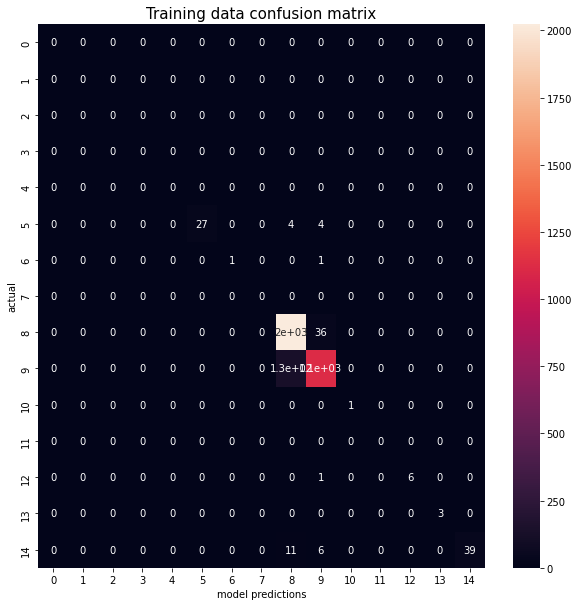

In [131]:
trainCM = trainConfusionMat

fig, ax = plt.subplots(1, figsize=(10,10))
sns.heatmap(trainCM, annot=True)
ax.set_xlabel('model predictions', fontsize=10)
ax.set_ylabel('actual', fontsize=10)
plt.title("Training data confusion matrix", fontsize=15);

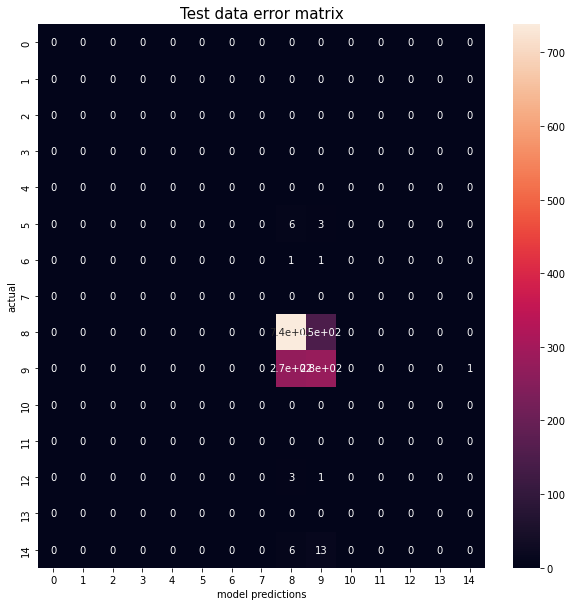

In [132]:
testEM = testErrorMat

fig, ax = plt.subplots(1, figsize=(10,10))
sns.heatmap(testEM, annot=True)
ax.set_xlabel('model predictions', fontsize=10)
ax.set_ylabel('actual', fontsize=10)
plt.title("Test data error matrix", fontsize=15);

In [133]:
# Define a region of interest as a rectangle.  Change the coordinates
# to get a classification of any place where there is imagery.
coords = geojson['features'][0]['geometry']['coordinates']
AOI = ee.Geometry.Polygon(coords)

# Chosen bands for prediction
bands = [ 'B1','B2', 'B3', 'B4', 'B5', 'B6', 'B7']

# Load Landsat 5 input imagery.
# 1. Filter to get only one year of images.
# 2. Filter to get only images under the region of interest.
# 3. Sort by scene cloudiness, ascending.
# 4. Get the first (least cloudy) scene.
# 5. Select 7 bands (fron 1 to 7)
landsat = ee.Image(ee.ImageCollection('LANDSAT/LT05/C01/T1_TOA')\
                    .filterDate('2011-01-01', '2020-12-31')\
                    .filterBounds(AOI)\
                    .sort('CLOUD_COVER')\
                    .first()\
                    .select(bands))


# Compute cloud score.
cloudScore = ee.Algorithms.Landsat.simpleCloudScore(landsat).select('cloud')

# Mask the input for clouds.  Compute the min of the input mask to mask
# pixels where any band is masked.  Combine that with the cloud mask.
Input = landsat.updateMask(landsat.mask().reduce('min').And(cloudScore.lte(50)))

# Use MODIS land cover, IGBP (International Geosphere-Biosphere Programme) classification, for training.
# This data set is one of the products of the International Satellite Land-Surface Climatology Project, 
# Initiative II (ISLSCP II) data collection.
modis = ee.Image('MODIS/051/MCD12Q1/2013_01_01').select('Land_Cover_Type_1')

# Sample the input imagery to get a FeatureCollection of training data.
# Get the values for all pixels in each polygon in the training.
training = Input.addBands(modis).sample(numPixels=5000, seed=0)
print(f"The number of total images is : {training.size().getInfo()}")
print()

# Make a Random Forest classifier and train it.
# classifier = ee.Classifier.randomForest(10).train(training, 'Land_Cover_Type_1')
classifier = ee.Classifier.smileRandomForest(10).train(training, 'Land_Cover_Type_1')

# Classify the input imagery.
classified = Input.classify(classifier)


# The randomColumn() method will add a column of uniform random
# numbers in a column named 'random' by default.
sample = training.randomColumn()

# Roughly 70% training, 30% testing.
split = 0.7  
trainingPartition = sample.filter(ee.Filter.lt('random', split))
testingPartition = sample.filter(ee.Filter.gte('random', split))

# train classifier
trainedclassifier = ee.Classifier.smileRandomForest(10).train(trainingPartition, 'Land_Cover_Type_1', inputProperties=bands)

# Get a confusion matrix representing resubstitution accuracy.
trainAccuracy = trainedclassifier.confusionMatrix()

# train confusion matrix into pandas
trainConfusionMat = pd.DataFrame(np.asarray(trainAccuracy.getInfo()))

print(f"The number of images for training Partition is : {trainingPartition.size().getInfo()}")
print()
print(f"Resubstitution error matrix : {trainAccuracy.getInfo()}")
print()
print(f"Training accuracy is : {100 *  trainAccuracy.accuracy().getInfo():.2f} %")
print()


# Classify the testing data.
tested = testingPartition.classify(trainedclassifier)

# Get a confusion matrix representing expected accuracy.
testAccuracy = tested.errorMatrix('Land_Cover_Type_1', 'classification')

# test error matrix into pandas
testErrorMat = pd.DataFrame(np.asarray(testAccuracy.getInfo()))

print(f"The number of images for test Partition is : {testingPartition.size().getInfo()}")
print()
print(f"Test error matrix : {testAccuracy.getInfo()}")
print()
print(f"Test accuracy is : {100 * testAccuracy.accuracy().getInfo():.2f} %")

# Define a palette for the IGBP classification.
igbpPalette = [
    'blue', # water
    'blueviolet', 'blueviolet', 'blueviolet', 'blueviolet', 'blueviolet', # forest
    'gray', 'gray', 'gray', 'gray', 'gray',  # shrub, grass
    'maroon', # wetlands
    'green', # croplands
    'yellow', # urban
    'black', # crop mosaic
    'chocolate', # snow and ice
    'cyan', # barren
    'darkorange'  # tundra
]

# Display the input and the classification.
Input_token = Input.getMapId({'bands': ['B4', 'B3'], 'max': 0.5}) # B4=NIR B3=Red
classified_token = classified.getMapId({'palette': igbpPalette, 'min': 0, 'max': 17})
center = [-12.57, 35.52]
Mapdisplay(center, {'Landsat':Input_token,'LandUse':classified_token}, zoom_start=8)

The number of total images is : 4642

The number of images for training Partition is : 3290

Resubstitution error matrix : [[964, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 58, 0, 0, 30, 1, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1368, 10, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 64, 541, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 4, 0, 0, 0, 0, 0, 0], [7, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 16, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 2, 7, 0, 0, 19, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 20, 35, 0, 0, 0, 0, 112, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [5, 0, 0, 0

The accuracy estimated from training data is an overestimate because the random forest is “fit” to the training data. The expected accuracy on unknown data is a bit lower (which is more better than the last one), as indicated by the estimate from the test data.

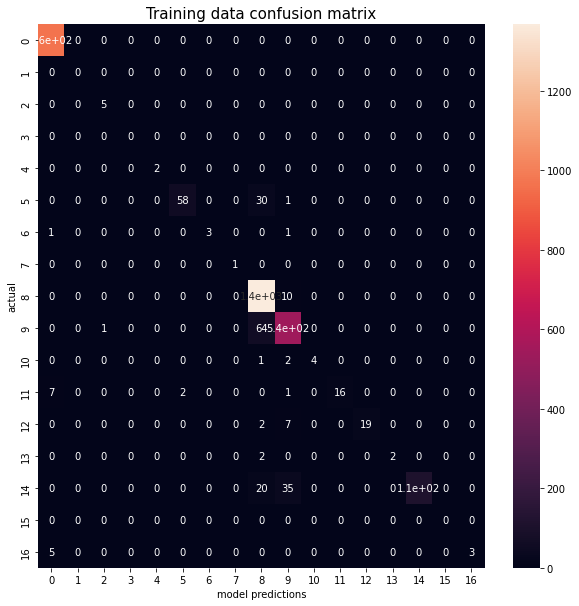

In [134]:
trainCM = trainConfusionMat

fig, ax = plt.subplots(1, figsize=(10,10))
sns.heatmap(trainCM, annot=True)
ax.set_xlabel('model predictions', fontsize=10)
ax.set_ylabel('actual', fontsize=10)
plt.title("Training data confusion matrix", fontsize=15);

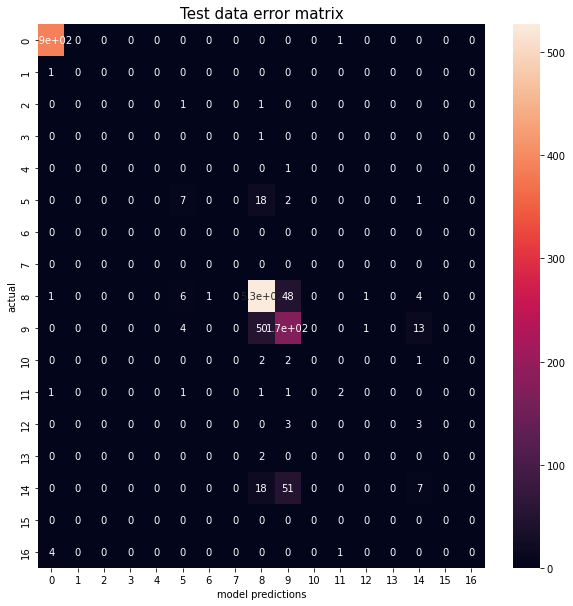

In [135]:
testEM = testErrorMat

fig, ax = plt.subplots(1, figsize=(10,10))
sns.heatmap(testEM, annot=True)
ax.set_xlabel('model predictions', fontsize=10)
ax.set_ylabel('actual', fontsize=10)
plt.title("Test data error matrix", fontsize=15);